**Start training res50 with only 3rd level labels. Free layer 4 and fc, With lr = 1e-2 for 1.2 epoch and lr = 1e-3 for 1 epoch, top1 accuracy reaches 64.2**

In [1]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct
from PIL import Image
import time
import shutil

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import *


In [2]:
train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images_all.csv", index_col=0)
val_images_df = pd.read_csv("val_images_all.csv", index_col=0)

/home/bowen/anaconda3/envs/cdiscount/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
data_dir = "./input/"
train_bson_path = os.path.join(data_dir, "train.bson")
train_bson_file = open(train_bson_path, "rb")

In [3]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

In [4]:
class BSONIterator(Dataset):
    def __init__(self, bson_file, images_df, offsets_df, transform, mode = 'train'):
        super(BSONIterator, self).__init__()
        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        image_row = self.images_df.iloc[idx]
        product_id = image_row["product_id"]
        offset_row = self.offsets_df.loc[product_id]
        # Random access this product's data from the BSON file.
        self.file.seek(offset_row["offset"])
        item_data = self.file.read(offset_row["length"])
        # Grab the image from the product.
        item = bson.BSON.decode(item_data)
        img_idx = image_row["img_idx"]
        bson_img = item["imgs"][img_idx]["picture"]

        # Load the image.
        image = io.BytesIO(bson_img)
        img = Image.open(image)
        x = self.transform(img)
        if self.mode == 'train':
            idx = int(image_row["category_idx"])
            level1 = int(idx2l1[idx])
            level2 = int(idx2l2[idx])
            
            target1 = torch.LongTensor([level1])
            target2 = torch.LongTensor([level2])
            target3 = torch.LongTensor([idx])
            return x, target1, target2, target3 #for the sake of pin_memory and async
        else:
            return x
    
    def __len__(self):
        return len(self.images_df)

In [8]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform_train = T.Compose([T.RandomHorizontalFlip(), 
                             T.ToTensor(),T.Normalize(mean=mean, std=std)])
transform_val = T.Compose([T.ToTensor(),T.Normalize(mean=mean, std=std)])

Create a generator for training and a generator for validation.

In [9]:
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, transform_train, mode = 'train')
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df, transform_val, mode = 'train')

In [10]:
print(len(train_gen), len(val_gen))

12129141 242152


In [11]:
batch_size = 256
loader_train = DataLoader(train_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(train_gen), num_workers=0, pin_memory = True)
loader_val = DataLoader(val_gen, batch_size=batch_size, 
                          sampler=sampler.RandomSampler(val_gen), num_workers=0, pin_memory = True)

In [12]:
print(len(loader_train), len(loader_val))

47380 946


# Training


**ResNet50**

In [13]:
model = torchvision.models.resnet50(pretrained=True)
model.avgpool = nn.AvgPool2d(kernel_size = 6)
model.fc = nn.Linear(in_features=2048, out_features=5270) #or 49 + 483 + 5270
#free layer 4 and fc layer.
for layer in [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/bowen/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 24402577.80it/s]


**Use another fc layer to map 1000 output to 5270 output. Not as good as 512 directly to 5270.**

In [ ]:
# class ResnetAffine(nn.Module):
#     def __init__(self, resnet, in_features, out_features):
#         super(ResnetAffine, self).__init__()
#         self.resnet = resnet
#         self.relu = nn.ReLU(inplace=True)
#         self.affine = nn.Linear(in_features=in_features, out_features=out_features)
        
#     def forward(self, x):
#         x = self.resnet(x)
#         x = self.relu(x)
#         x = self.affine(x)
#         return x

In [ ]:
# resnet = torchvision.models.resnet18(pretrained=True)
# resnet.avgpool = nn.AvgPool2d(kernel_size = 5)
# for param in resnet.parameters():
#     param.requires_grad = False
# for param in resnet.fc.parameters():
#     param.requires_grad = True
# model = ResnetAffine(resnet, 1000, 5270)
# model.affine.bias.data.zero_()
# init.kaiming_uniform(model.affine.weight.data)
# model.cuda()

In [14]:
init.kaiming_normal(model.fc.weight.data)
model.fc.bias.data.zero_()
model.cuda()


ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [15]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(lr, optimizer, epoch, denominator = 2):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // denominator))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)
    _, pred = output.max(dim=1)
    correct = pred.eq(target)
    res = []
    for k in topk:
        correct_k = correct.float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [20]:
def train(train_loader, model, criterion, optimizer, epoch, print_freq = 500):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    loss_log = []
    acc_log = []

    # switch to train mode
    model.train()

    end = time.time()
    for i, (img, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img)
        target_var = Variable(target)

        # compute output
        output = model(img_var)
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1, ))[0]#only need top1
        losses.update(loss.data[0], img.size(0)) #[0] to take out the float inside torch.Tensor
        top1.update(prec1[0], img.size(0))
        loss_log.append(losses.val)
        acc_log.append(top1.val)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))
#         if i == 10000: #for test only
#             break
    return loss_log, acc_log

In [17]:
def validate(val_loader, model, print_freq=50):
    batch_time = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (img, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        img = img.cuda(async=True)
        img_var = Variable(img, volatile=True)
        target_var = Variable(target, volatile=True)

        # compute output
        output = model(img_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]#only need top1
        top1.update(prec1[0], img.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [21]:
def main():
    best_prec1 = 58
    criterion = nn.CrossEntropyLoss().cuda()
    lr = 1e-2
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr = lr, momentum=0.9, 
                          weight_decay=0)
    resume = None
    start_epoch = 0
    epochs = 2
    arch = 'resnet50'

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    for epoch in range(start_epoch, epochs):

        adjust_learning_rate(lr=lr, optimizer=optimizer, epoch=epoch, denominator=1) #decay is 1 epoch.

        # train for one epoch
        loss_log, acc_log = train(train_loader=loader_train, model=model, criterion=criterion,
                                  optimizer=optimizer, epoch=epoch)

        # evaluate on validation set
        prec1 = validate(val_loader=loader_val, model=model)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best)

        #plot loss and acc
        fig = plt.figure(figsize = (6,3), dpi = 1200)
        loss_log = np.array(loss_log)
        ax1 = plt.subplot(121)
        ax1.plot(loss_log)
        ax1.set_ylabel('Loss', weight = 'bold')
        acc_log = np.array(acc_log)
        ax2 = plt.subplot(111)
        ax2.plot(acc_log)
        ax2.set_ylabel('Train_accuracy', weight = 'bold')
        np.savetxt(X=np.vstack((loss_log, acc_log)), fname='loss_acc_log.txt', fmt='%.3f')

Epoch: [0][0/47380]	Time 3.055 (3.055)	Data 1.120 (1.120)	Loss 8.9059 (8.9059)	Prec@1 0.000 (0.000)
Epoch: [0][500/47380]	Time 0.676 (0.687)	Data 0.329 (0.338)	Loss 4.1459 (4.7916)	Prec@1 34.375 (28.988)
Epoch: [0][1000/47380]	Time 0.697 (0.682)	Data 0.350 (0.334)	Loss 3.6528 (4.2623)	Prec@1 38.281 (33.736)
Epoch: [0][1500/47380]	Time 0.704 (0.688)	Data 0.334 (0.339)	Loss 3.2729 (3.9860)	Prec@1 42.969 (36.327)
Epoch: [0][2000/47380]	Time 0.670 (0.685)	Data 0.325 (0.336)	Loss 3.2484 (3.7987)	Prec@1 41.016 (38.123)
Epoch: [0][2500/47380]	Time 0.671 (0.682)	Data 0.322 (0.333)	Loss 2.8408 (3.6605)	Prec@1 47.266 (39.477)
Epoch: [0][3000/47380]	Time 0.660 (0.679)	Data 0.314 (0.331)	Loss 3.1662 (3.5540)	Prec@1 42.188 (40.525)
Epoch: [0][3500/47380]	Time 0.661 (0.677)	Data 0.317 (0.329)	Loss 3.0147 (3.4666)	Prec@1 48.047 (41.434)
Epoch: [0][4000/47380]	Time 0.700 (0.677)	Data 0.355 (0.329)	Loss 2.8607 (3.3924)	Prec@1 48.438 (42.222)
Epoch: [0][4500/47380]	Time 0.696 (0.679)	Data 0.351 (0.331)	

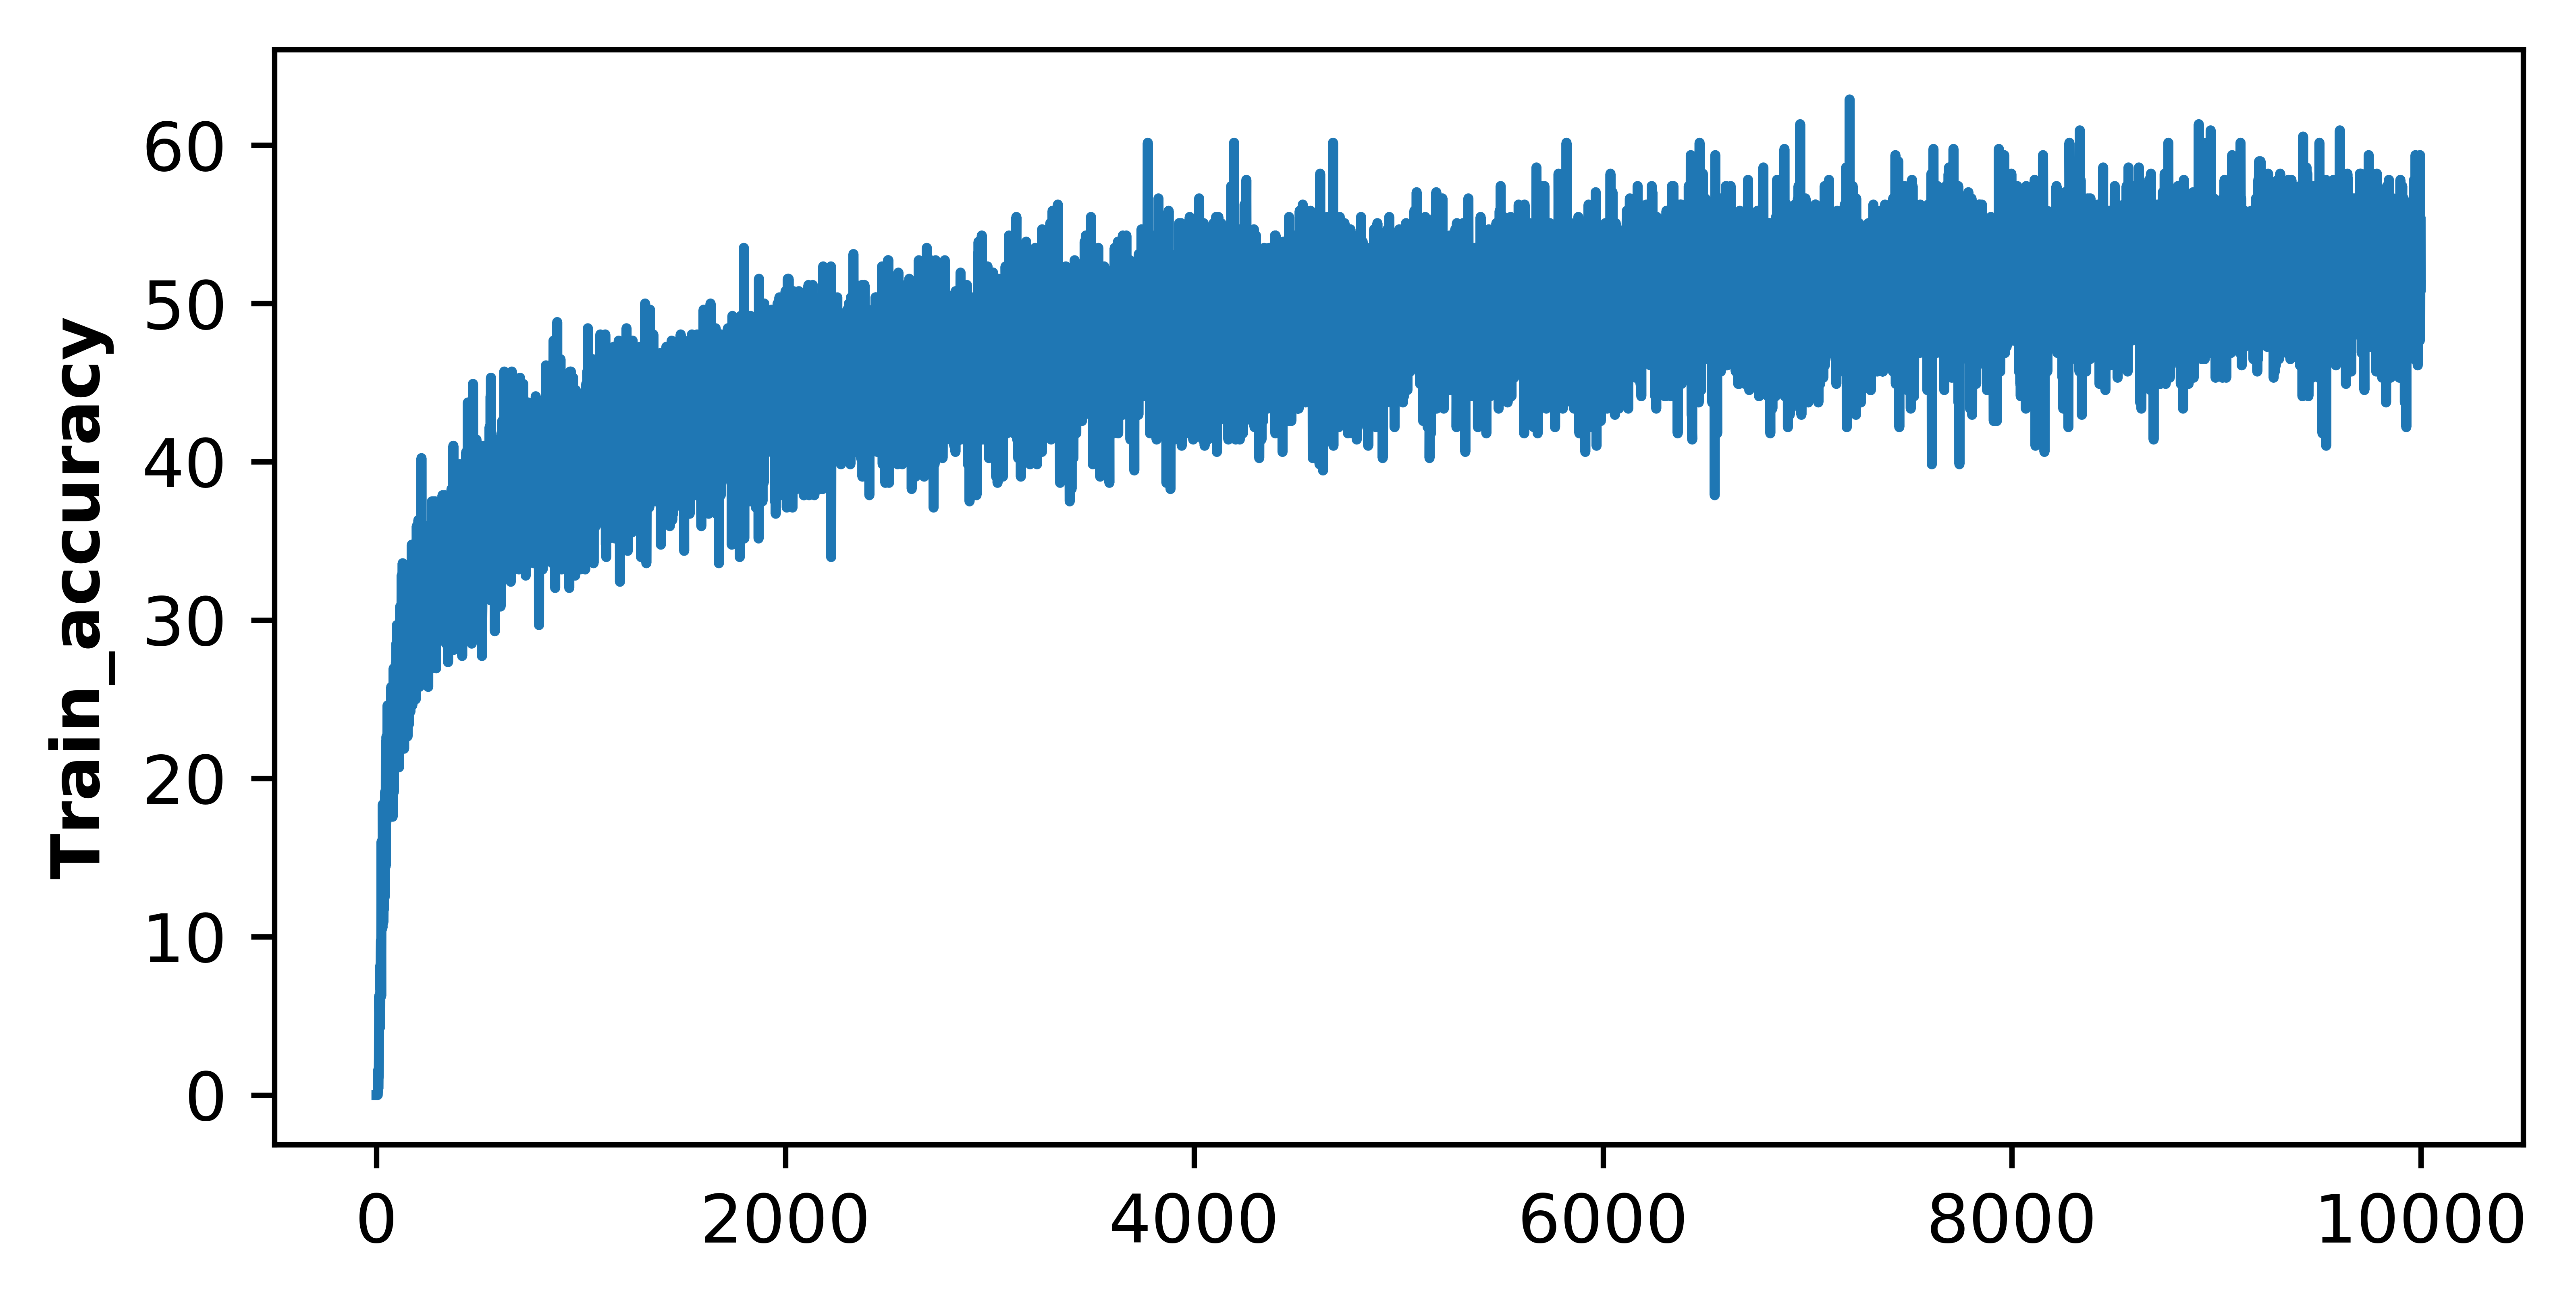

In [19]:
main()

Epoch: [0][0/47380]	Time 1.099 (1.099)	Data 0.719 (0.719)	Loss 2.3413 (2.3413)	Prec@1 54.688 (54.688)
Epoch: [0][500/47380]	Time 0.665 (0.668)	Data 0.314 (0.320)	Loss 2.3740 (2.4489)	Prec@1 51.562 (52.566)
Epoch: [0][1000/47380]	Time 0.665 (0.665)	Data 0.316 (0.318)	Loss 2.3728 (2.4416)	Prec@1 53.906 (52.722)
Epoch: [0][1500/47380]	Time 0.667 (0.666)	Data 0.318 (0.319)	Loss 2.2147 (2.4338)	Prec@1 57.812 (52.862)
Epoch: [0][2000/47380]	Time 0.662 (0.667)	Data 0.315 (0.319)	Loss 2.3419 (2.4260)	Prec@1 53.906 (52.954)
Epoch: [0][2500/47380]	Time 0.661 (0.667)	Data 0.316 (0.319)	Loss 2.3232 (2.4187)	Prec@1 54.688 (53.048)
Epoch: [0][3000/47380]	Time 0.662 (0.667)	Data 0.316 (0.319)	Loss 2.4859 (2.4139)	Prec@1 52.344 (53.121)
Epoch: [0][3500/47380]	Time 0.711 (0.667)	Data 0.353 (0.319)	Loss 2.5258 (2.4068)	Prec@1 53.906 (53.222)
Epoch: [0][4000/47380]	Time 0.679 (0.666)	Data 0.324 (0.319)	Loss 2.2440 (2.4000)	Prec@1 55.469 (53.310)
Epoch: [0][4500/47380]	Time 0.660 (0.666)	Data 0.312 (0.318

Epoch: [0][39000/47380]	Time 0.654 (0.658)	Data 0.309 (0.314)	Loss 1.9037 (2.1466)	Prec@1 57.031 (56.806)
Epoch: [0][39500/47380]	Time 0.659 (0.658)	Data 0.317 (0.314)	Loss 1.8615 (2.1442)	Prec@1 58.203 (56.836)
Epoch: [0][40000/47380]	Time 0.654 (0.658)	Data 0.312 (0.314)	Loss 1.7197 (2.1420)	Prec@1 64.453 (56.868)
Epoch: [0][40500/47380]	Time 0.648 (0.658)	Data 0.304 (0.314)	Loss 1.9974 (2.1398)	Prec@1 58.984 (56.899)
Epoch: [0][41000/47380]	Time 0.649 (0.658)	Data 0.305 (0.314)	Loss 2.1210 (2.1377)	Prec@1 55.469 (56.931)
Epoch: [0][41500/47380]	Time 0.647 (0.658)	Data 0.305 (0.313)	Loss 1.8773 (2.1355)	Prec@1 58.984 (56.963)
Epoch: [0][42000/47380]	Time 0.652 (0.658)	Data 0.306 (0.313)	Loss 1.8999 (2.1333)	Prec@1 58.984 (56.994)
Epoch: [0][42500/47380]	Time 0.649 (0.658)	Data 0.306 (0.313)	Loss 2.1429 (2.1311)	Prec@1 57.812 (57.024)
Epoch: [0][43000/47380]	Time 0.653 (0.658)	Data 0.308 (0.313)	Loss 2.0825 (2.1290)	Prec@1 57.422 (57.052)
Epoch: [0][43500/47380]	Time 0.656 (0.658)	Dat

Epoch: [1][25000/47380]	Time 0.655 (0.657)	Data 0.311 (0.313)	Loss 1.4539 (1.7047)	Prec@1 67.969 (63.819)
Epoch: [1][25500/47380]	Time 0.659 (0.657)	Data 0.314 (0.313)	Loss 1.7635 (1.7044)	Prec@1 64.453 (63.826)
Epoch: [1][26000/47380]	Time 0.666 (0.657)	Data 0.321 (0.313)	Loss 1.5614 (1.7039)	Prec@1 66.406 (63.832)
Epoch: [1][26500/47380]	Time 0.676 (0.657)	Data 0.331 (0.313)	Loss 1.7026 (1.7033)	Prec@1 64.453 (63.844)
Epoch: [1][27000/47380]	Time 0.644 (0.657)	Data 0.300 (0.313)	Loss 1.6968 (1.7026)	Prec@1 61.719 (63.856)
Epoch: [1][27500/47380]	Time 0.647 (0.657)	Data 0.301 (0.313)	Loss 1.5043 (1.7022)	Prec@1 66.797 (63.863)
Epoch: [1][28000/47380]	Time 0.642 (0.657)	Data 0.299 (0.313)	Loss 1.8327 (1.7018)	Prec@1 63.281 (63.873)
Epoch: [1][28500/47380]	Time 0.641 (0.656)	Data 0.298 (0.312)	Loss 1.5942 (1.7011)	Prec@1 66.406 (63.883)
Epoch: [1][29000/47380]	Time 0.644 (0.656)	Data 0.299 (0.312)	Loss 1.7912 (1.7006)	Prec@1 56.641 (63.893)
Epoch: [1][29500/47380]	Time 0.645 (0.656)	Dat

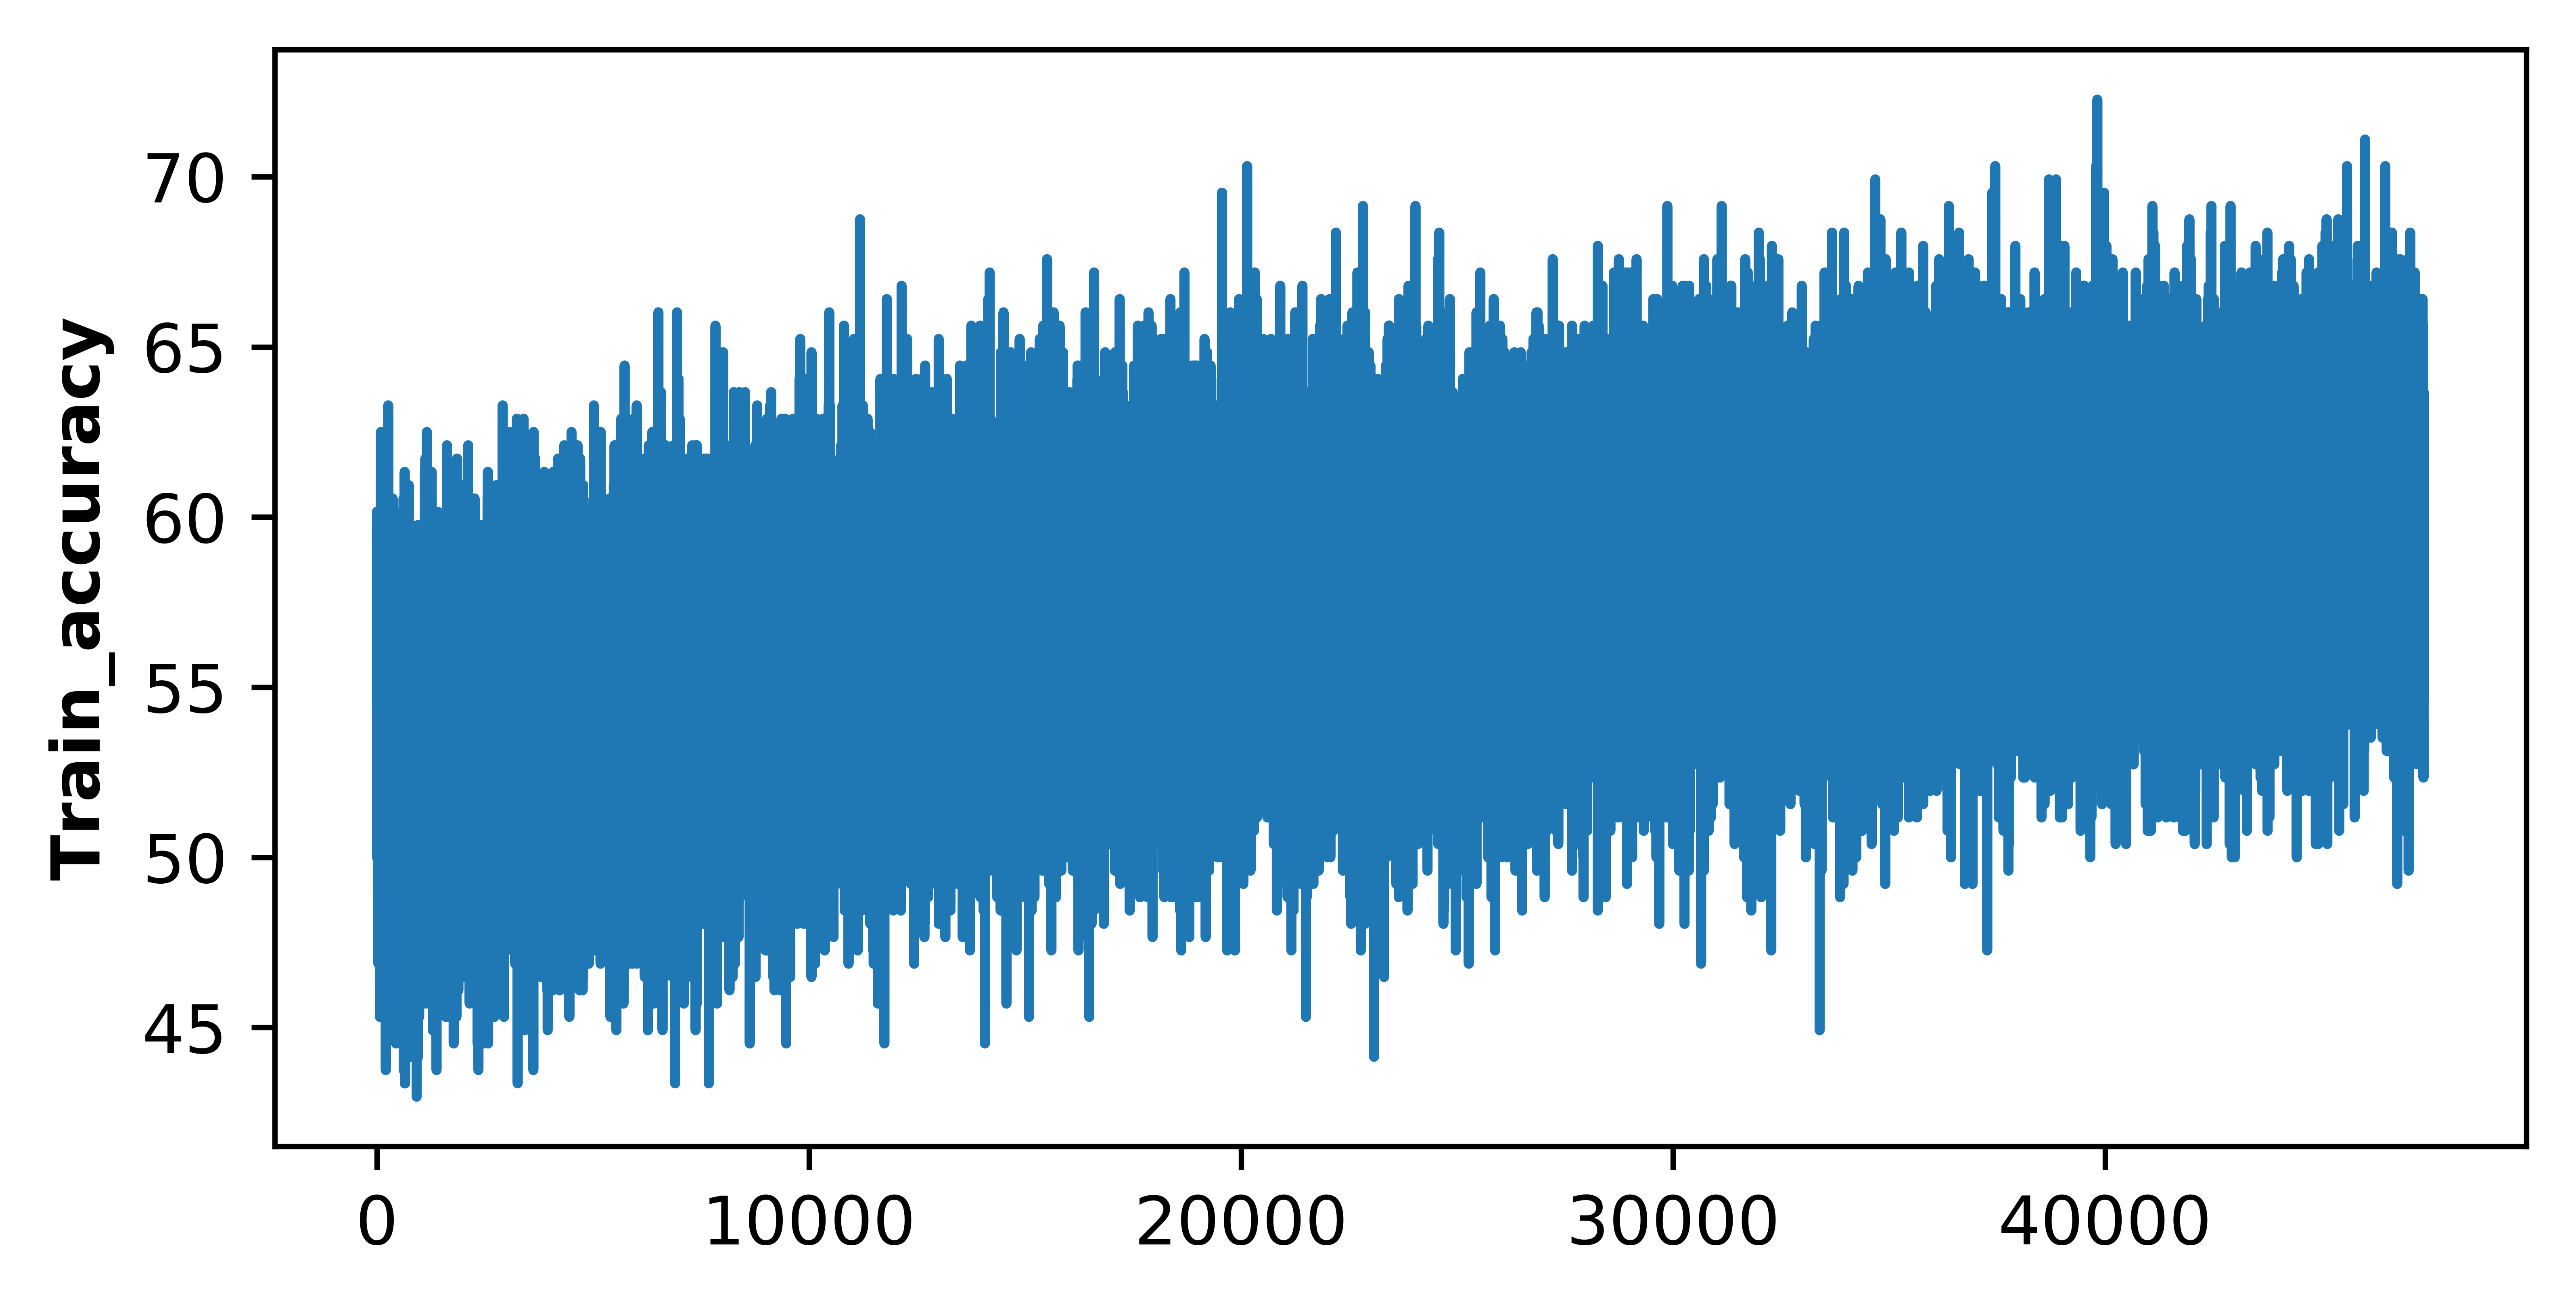

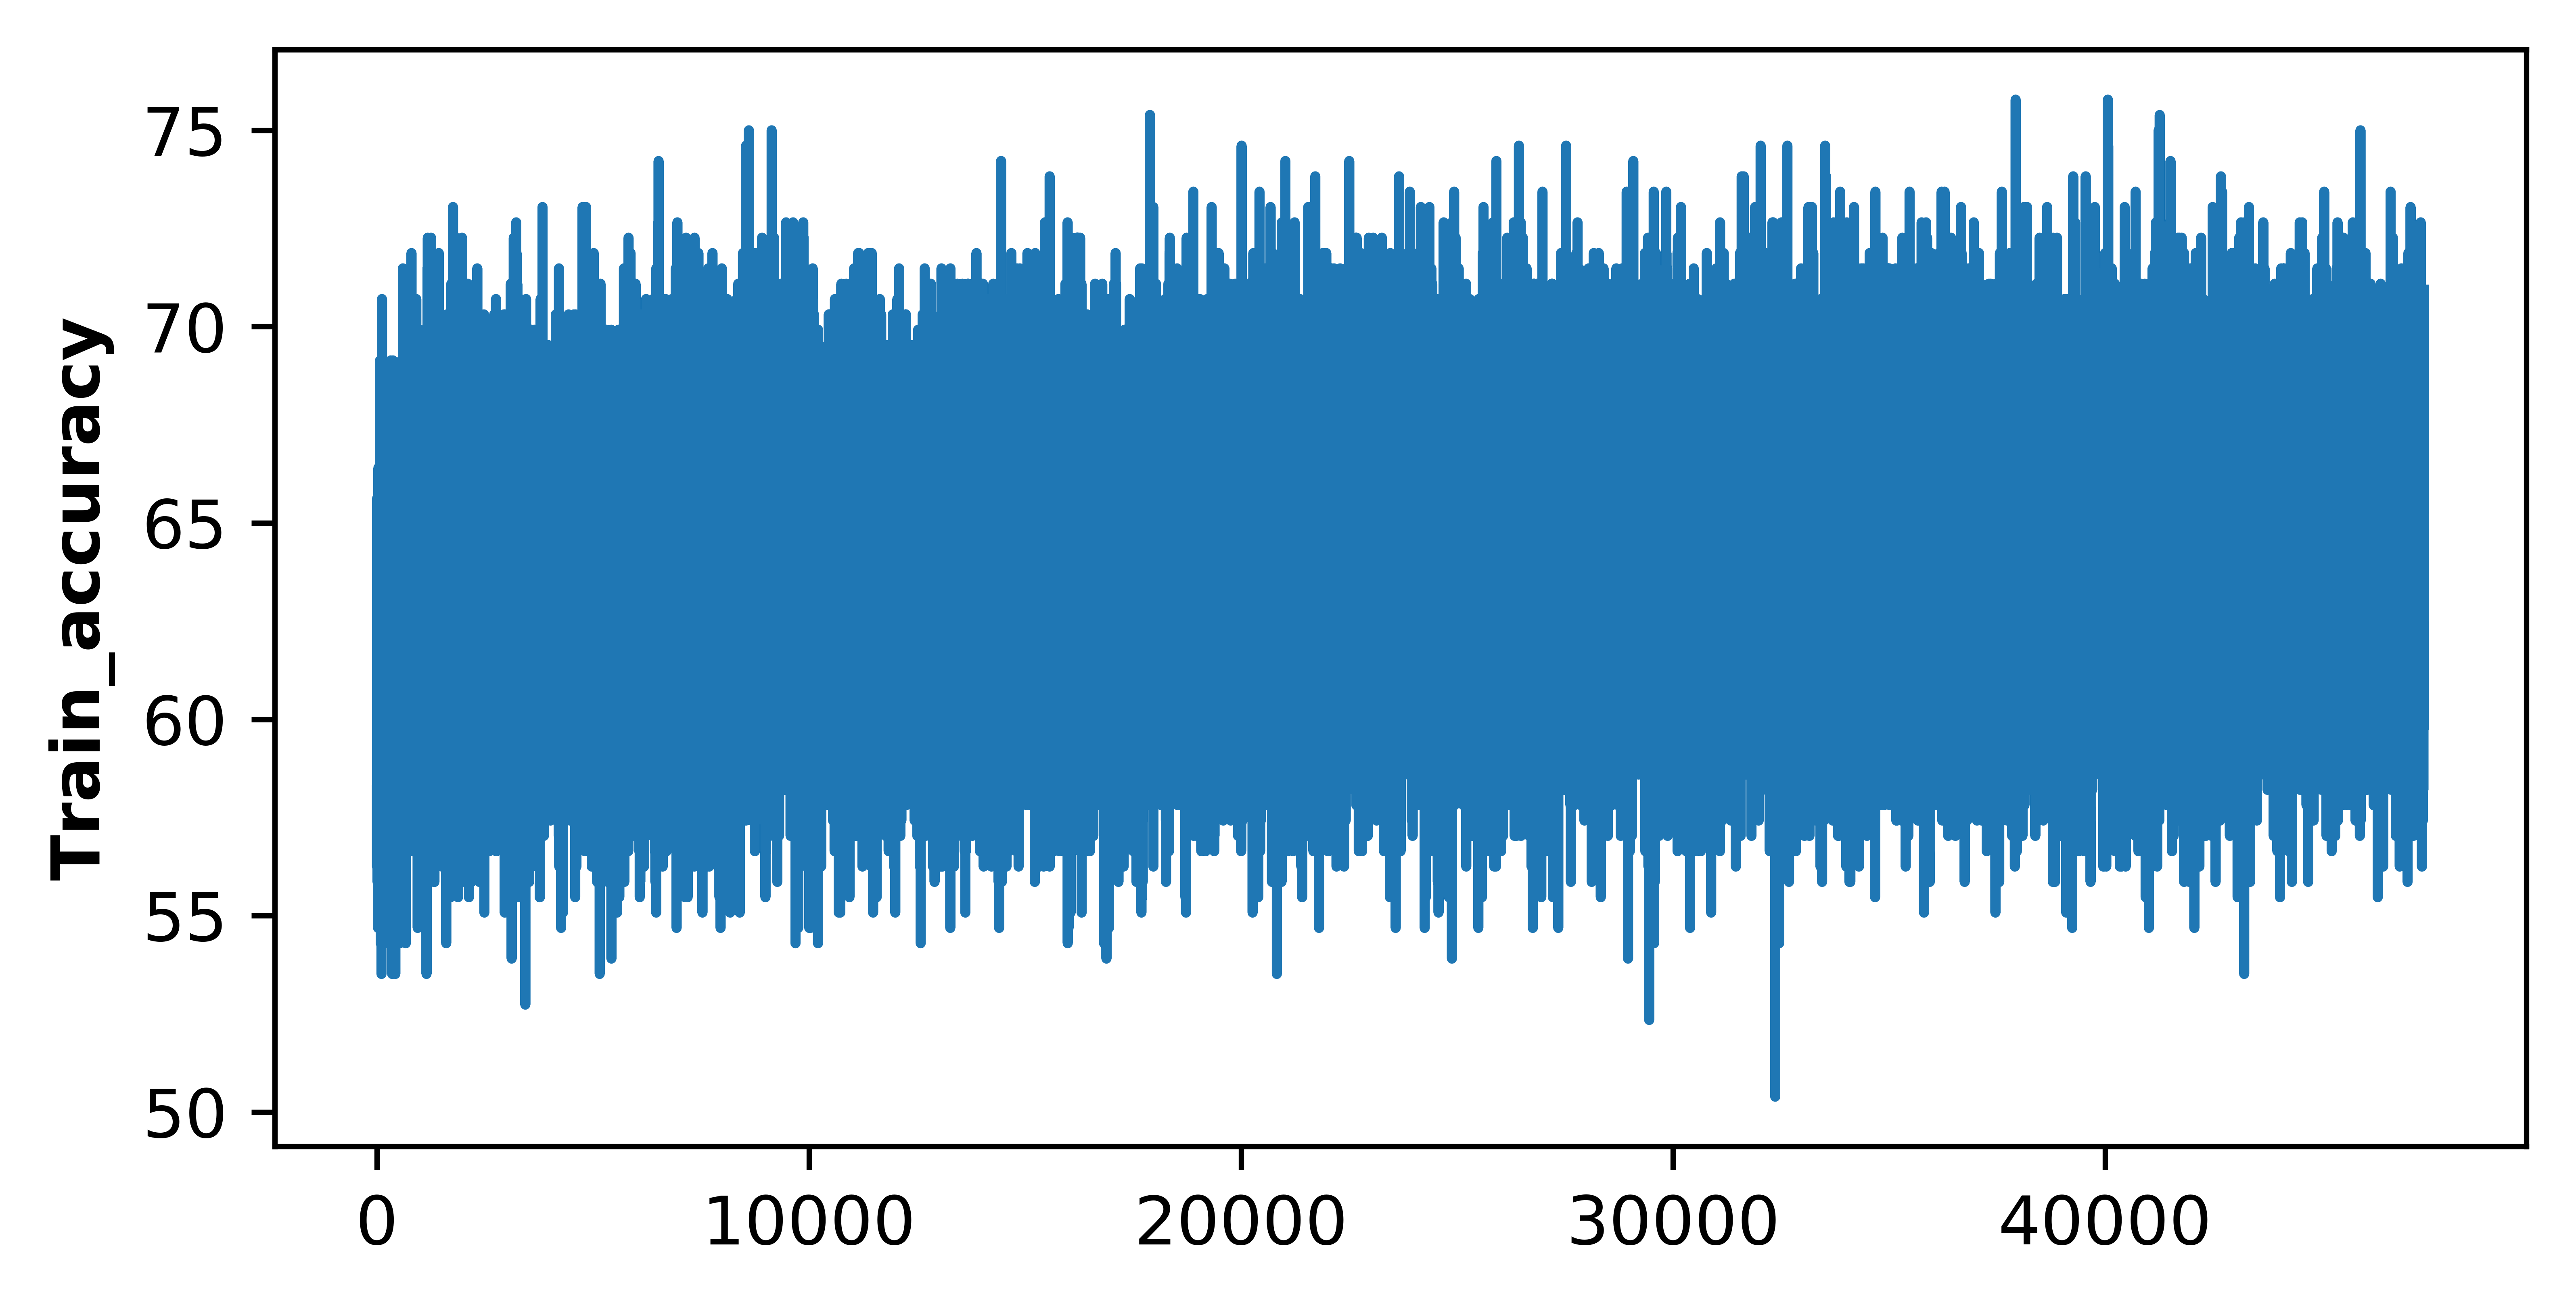

In [22]:
main()